In [1]:
import torch
import time
import matplotlib.pyplot as plt


from python.SelfAttention import SelfAttention as SelfAttentionPython
from extended.SelfAttention import SelfAttention as SelfAttentionExt

In [2]:


# Set random seed for reproducibility
torch.manual_seed(42)

class ExperimentConfig:
    def __init__(self, device_pref = 'cuda', n_runs = 10000):
        self.device = torch.device(device_pref if torch.cuda.is_available() else 'cpu')
        self.n_runs = n_runs
        
    def set_attention_params(self, *args):
        if len(args) == 1:
            batch_size, sequence_length, heads, embed_size = args[0]
        elif len(args) == 4:
            batch_size, sequence_length, heads, embed_size = args
        else:
            raise Exception('invalid args format')
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.heads = heads
        self.embed_size = embed_size
        return self
        
    def __str__(self) -> str:
        return self.get_config_log()
    def get_config_log(self):
        return f'Batch Size: {self.batch_size}, Seq Length: {self.sequence_length}, Heads: {self.heads}, Embed Size: {self.embed_size}'
        
def run_experiment(exp, ModelClass):
    device = exp.device
    n_runs = exp.n_runs
    embed_size = exp.embed_size
    heads = exp.heads
    sequence_length = exp.sequence_length
    batch_size = exp.batch_size
    
    values = torch.randn(batch_size, sequence_length, embed_size, device=device)
    keys = torch.randn(batch_size, sequence_length, embed_size, device=device)
    queries = torch.randn(batch_size, sequence_length, embed_size, device=device)
    mask = torch.ones(1,sequence_length, device=device)  # No masking for simplicity

    model = ModelClass(embed_size, heads)
    model.reset_parameters()
    model = model.to(device)

    forward = 0
    backward = 0
    for _ in range(n_runs):
        start = time.time()
        output = model(values, keys, queries, mask)
        forward += time.time() - start

        loss = output.sum() # only for perf testing
        start = time.time()
        loss.backward()
        backward += time.time() - start
    forward = forward*1e6/n_runs
    backward = backward*1e6/n_runs
    print('{}: [{}]'.format(model.__str__(), exp.get_config_log()))
    print('| Forward: {:.3f} μs | Backward {:.3f} μs'.format(forward, backward))
    return forward, backward

def validate_behavior(ModelClass1, ModelClass2, model_weights, exp):
    device = exp.device
    n_runs = exp.n_runs
    embed_size = exp.embed_size
    heads = exp.heads
    sequence_length = exp.sequence_length
    batch_size = exp.batch_size
    
    values = torch.randn(batch_size, sequence_length, embed_size, device=device)
    keys = torch.randn(batch_size, sequence_length, embed_size, device=device)
    queries = torch.randn(batch_size, sequence_length, embed_size, device=device)
    mask = torch.ones(1,sequence_length, device=device)  # No masking for simplicity

    model1 = ModelClass1(embed_size, heads)
    model1.reset_parameters(model_weights)
    model1 = model1.to(device)
    model2 = ModelClass2(embed_size, heads)
    model2.reset_parameters(model_weights)
    model2 = model2.to(device)

    output1 = model1(values, keys, queries, mask)
    output2 = model2(values, keys, queries, mask)
    
    if torch.allclose(output1, output2):
        print(f'Model behavior accurate! Sum absolute error: {(output1-output2).abs().sum()}')
        

In [3]:
# Validate model behaviors for Python and C++ implementations

model_weights = torch.load('layer_test_weights.pt')
exp = ExperimentConfig().set_attention_params(8,10,4,64)
validate_behavior(SelfAttentionPython, SelfAttentionExt, model_weights, exp)

Model behavior accurate! Sum absolute error: 0.0


In [4]:

# Run experiments for different attention hyper parameters
# Params are in the order: (batch_size, sequence_length, heads, embed_size)
import numpy as np
import itertools

exp = ExperimentConfig()
batch_sizes = [16]
sequence_lengths = [10, 15, 20, 25, 30]
heads = [8]
embed_sizes = [64, 128, 256, 512, 1024]

attention_params = list(itertools.product(batch_sizes, sequence_lengths, heads, embed_sizes))

result_matrix = np.zeros((len(attention_params), 8))

# Fill in the values row by row
for i, attn_params in enumerate(attention_params):
    exp.set_attention_params(*attn_params)
    fp, bp = run_experiment(exp, SelfAttentionPython)
    fe, be = run_experiment(exp, SelfAttentionExt)
    result_matrix[i] = [*attn_params, fp, bp, fe, be]

# Print the result matrix
# print(result_matrix)


SelfAttention-Python: [Batch Size: 16, Seq Length: 10, Heads: 8, Embed Size: 64]
| Forward: 652.173 μs | Backward 977.133 μs
SelfAttention-Extended: [Batch Size: 16, Seq Length: 10, Heads: 8, Embed Size: 64]
| Forward: 442.050 μs | Backward 1048.186 μs
SelfAttention-Python: [Batch Size: 16, Seq Length: 10, Heads: 8, Embed Size: 128]
| Forward: 611.940 μs | Backward 885.956 μs
SelfAttention-Extended: [Batch Size: 16, Seq Length: 10, Heads: 8, Embed Size: 128]
| Forward: 447.146 μs | Backward 1057.088 μs
SelfAttention-Python: [Batch Size: 16, Seq Length: 10, Heads: 8, Embed Size: 256]
| Forward: 711.214 μs | Backward 985.473 μs
SelfAttention-Extended: [Batch Size: 16, Seq Length: 10, Heads: 8, Embed Size: 256]
| Forward: 479.777 μs | Backward 1145.667 μs
SelfAttention-Python: [Batch Size: 16, Seq Length: 10, Heads: 8, Embed Size: 512]
| Forward: 639.564 μs | Backward 900.865 μs
SelfAttention-Extended: [Batch Size: 16, Seq Length: 10, Heads: 8, Embed Size: 512]
| Forward: 522.705 μs | Bac

In [10]:

# CPU runs
# SelfAttentionCustom | Forward: 0.003465 s | Backward 0.006476 s
# SelfAttention | Forward: 0.004863 s | Backward 0.005056 s


# CUDA runs
# GPU | SelfAttentionCustom | Forward: 619.070 μs | Backward 1141.094 μs
# GPU | SelfAttention | Forward: 951.625 μs | Backward 1176.297 μs

# GPU | SelfAttentionCustom | Forward: 789.302 μs | Backward 1287.836 μs
# GPU | SelfAttention | Forward: 1012.441 μs | Backward 1103.148 μs

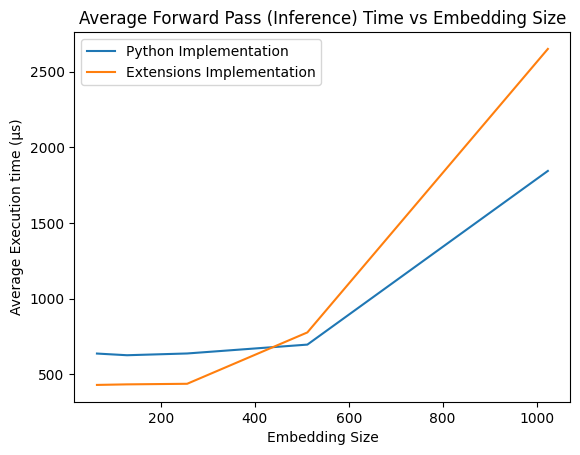

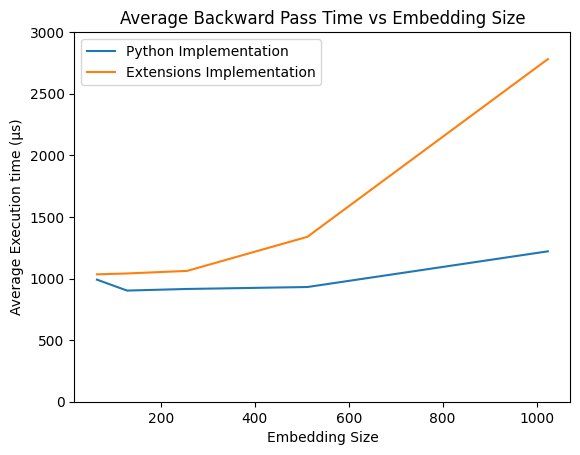

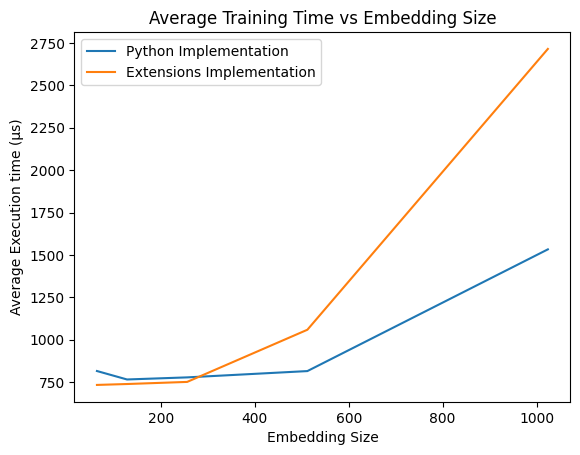

In [37]:
fp_times = []
bp_times = []
fe_times = []
be_times = []
avgp_times = []
avge_times = []
for es in embed_sizes:
    rm = result_matrix[result_matrix[:, 3] == es]
    fp_time = rm[:, 4].mean()
    bp_time = rm[:, 5].mean()
    fe_time = rm[:, 6].mean()
    be_time = rm[:, 7].mean()
    
    fp_times.append(fp_time)
    bp_times.append(bp_time)
    fe_times.append(fe_time)
    be_times.append(be_time)
    avgp_times.append((fp_time+bp_time)/2)
    avge_times.append((fe_time+be_time)/2)


plt.plot(embed_sizes, fp_times, label='Python Implementation')
plt.plot(embed_sizes, fe_times, label='Extensions Implementation')
plt.xlabel('Embedding Size')
plt.ylabel('Average Execution time (μs)')
plt.title('Average Forward Pass (Inference) Time vs Embedding Size')
plt.legend()
plt.show()


plt.plot(embed_sizes, bp_times, label='Python Implementation')
plt.plot(embed_sizes, be_times, label='Extensions Implementation')
plt.xlabel('Embedding Size')
plt.ylabel('Average Execution time (μs)')
plt.title('Average Backward Pass Time vs Embedding Size')
plt.legend()
plt.ylim(0, 3000)
plt.show()


plt.plot(embed_sizes, avgp_times, label='Python Implementation')
plt.plot(embed_sizes, avge_times, label='Extensions Implementation')
plt.xlabel('Embedding Size')
plt.ylabel('Average Execution time (μs)')
plt.title('Average Training Time vs Embedding Size')
plt.legend()
plt.show()

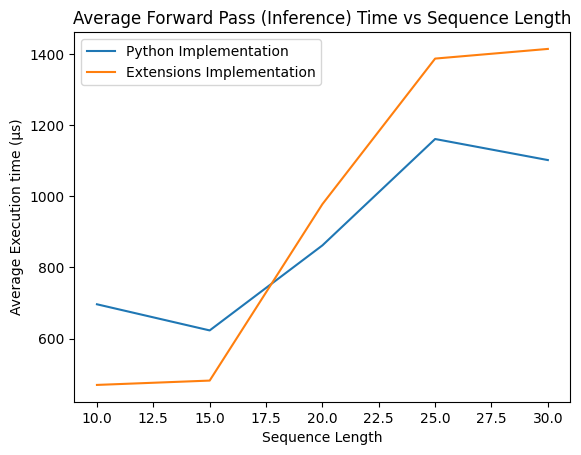

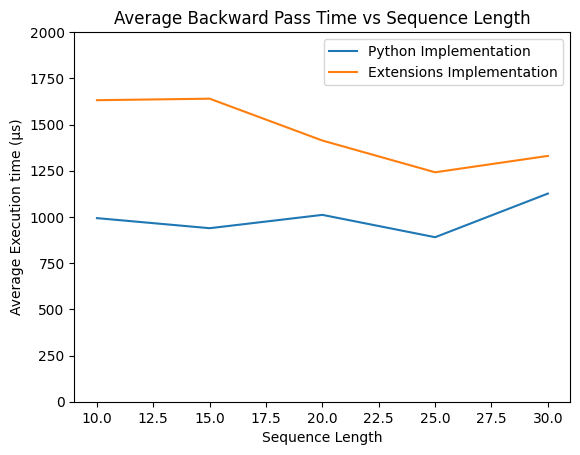

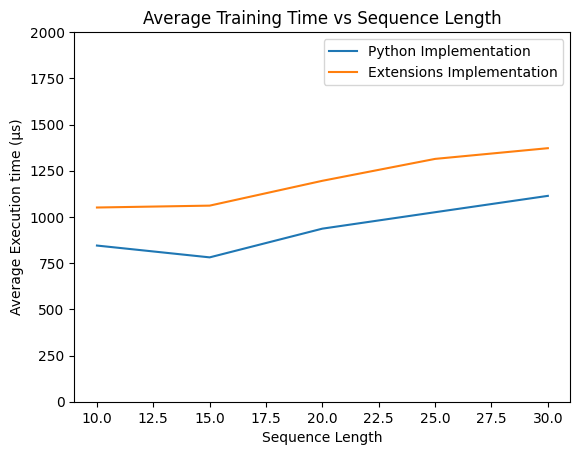

In [39]:
fp_times = []
bp_times = []
fe_times = []
be_times = []
avgp_times = []
avge_times = []
for sl in sequence_lengths:
    rm = result_matrix[result_matrix[:, 1] == sl]
    fp_time = rm[:, 4].mean()
    bp_time = rm[:, 5].mean()
    fe_time = rm[:, 6].mean()
    be_time = rm[:, 7].mean()
    
    fp_times.append(fp_time)
    bp_times.append(bp_time)
    fe_times.append(fe_time)
    be_times.append(be_time)
    avgp_times.append((fp_time+bp_time)/2)
    avge_times.append((fe_time+be_time)/2)


plt.plot(sequence_lengths, fp_times, label='Python Implementation')
plt.plot(sequence_lengths, fe_times, label='Extensions Implementation')
plt.xlabel('Sequence Length')
plt.ylabel('Average Execution time (μs)')
plt.title('Average Forward Pass (Inference) Time vs Sequence Length')
plt.legend()
plt.show()


plt.plot(sequence_lengths, bp_times, label='Python Implementation')
plt.plot(sequence_lengths, be_times, label='Extensions Implementation')
plt.xlabel('Sequence Length')
plt.ylabel('Average Execution time (μs)')
plt.title('Average Backward Pass Time vs Sequence Length')
plt.legend()
plt.ylim(0, 2000)
plt.show()

plt.plot(sequence_lengths, avgp_times, label='Python Implementation')
plt.plot(sequence_lengths, avge_times, label='Extensions Implementation')
plt.xlabel('Sequence Length')
plt.ylabel('Average Execution time (μs)')
plt.title('Average Training Time vs Sequence Length')
plt.legend()
plt.ylim(0, 2000)
plt.show()